<a href="https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/TPU_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rethinking molecular dynamics simulations for machine learning accelerators

Authors: Sam Schoenholz (schsam@) and Jascha Sohl-Dickstein (jaschasd@)

## Introduction

Current molecular dynamics simulations are poorly suited to modern machine learning accelerators such as TPUs. TPUs are typically highly optimized for matrix multiplication and convolutions, but have limited support for the primitives underlying molecular dynamics such as neighborhood identification. However, there could be significant benefit if molecular dynamics simulations could harness TPUs. As opposed to GPUs, TPUs are designed to enable extremely large, parallel, computations without needing to communicate with CPU hosts. This could enable cost-efficient, extremely large molecular dynamics simulations. Moreover, TPUs are very well-suited for machine learning models; as atomic potentials and forces become increasingly well-approximated by neural networks, there might be significant advantages to simulating systems on TPU.

To this end, we reformulate traditional molecular dynamics simulations to leverage primitives that are well-suited to TPUs and other machine learning accelerators. Specifically, we introduce a fully-differentiable formulation of molecular dynamics that allows us to use convolutions to compute energies and forces. Our approach is based on several core innovations:


1. Particles are stored on a grid with at most one particle stored per cell. Naively, this approach would lead to difficulties packing dense configurations of particles. We overcome these difficulties by only weakly coupling the grid cell in which a particle’s state is stored to the location of the particle.

2. Interactions and forces between particles are computed using separable convolutions over the particle storage grid.

3. Particle motion is accommodated by swapping cell occupancy when particles have moved beyond the bounds of a cell. In the case of frustration, cells are assigned to particles by minimizing the norm of the deviation of particle coordinates from the corresponding cells.

4. To enable simulations to be parallelized across many accelerators and to take advantage of batch processing on each accelerator, the grid is split spatially into "folds" or "chunks" and the different chunks are processed in parallel.

Together, this approach allows us to scale molecular dynamics simulations to XXX millions of particles across thousands of TPU cores with nearly perfect scaling. Here we will outline the specifics of our approach, demonstrate performance scaling from a single TPU chip to an entire TPU pod, and include an interactive demo that can be run on a 2x2 TPU in the cloud. 

### Summary animation

The animation below shows a simulation of particles in a 2d grid with circular boundary conditions. Each particle is shown tethered to the grid cell that is storing its information. Particle position is represented as an offset from grid cells' centers. As particles move, they swap the cells in which they are stored. Interactions between particles are computed using seperable convolutions on the grid. The yellow highlight shows the grid cells that a single particle (highlighted orange) can interact with, as it traverses the space. The width of the yellow highlighted region is the same as the width of the convolution kernels used to compute interactions.

<img src='https://raw.githubusercontent.com/google/jax-md/main/notebooks/data/TPU_particle_animation.gif'></img>

## Details of the approach

Implementing our approach involves two main technical challenges.
We describe our solutions to these challenges here.
First, is the storage of particles and the manner in which we accommodate particle motion during the simulation. Second is the way in which we compute displacements and interactions using separable convolutions. 

### Particle storage

#### Grid holding particle positions and attributes

Consider a collection of particles in $d$-dimensions at positions $\{\vec r_i\in\mathbb R^d\}$ in a box of side-length $L$, and where $i$ indicates particle index. We assume that particle interactions are local in the sense that particles only interact when they are closer than a maximmum interaction distance $\xi$, such that $\|\vec r_i - \vec r_j\| \leq \xi$. We discretize the box into cells of length $\ell$ and define the grid $\vec g_{\vec n}\in\mathbb R^{d + 1}$ with $\vec n\in\mathbb Z^d$ a $d$-dimensional index into the grid. Note that a grid cell located at $\vec n$ will have center at $\vec c_{\vec n} = (\vec n + \frac{1}{2})\ell$.

We wish to set 
$$\vec g_{\vec n} = \begin{cases}\left[\begin{array}\vec r_i - \vec c_{\vec n}\\ i\end{array}\right] & \text{if particle $i$ is in cell $\vec n$}\\ 0 & \text{if no particle is in cell $\vec n$}\end{cases}$$

Said differently, we would like each grid cell to be zero if no particle is occupying it. If a particle is occupying a cell, we would like to set the first $d$ components of the grid to be the offset of the particle from its center and the final component should be set to the (1-indexed) ID of the particle. This can be seen schematically in the figure below. If there is additional meta-information associated with a particle, it can also be appended as additional channels. For instance, in most examples, we also append channels containing particle momentum.

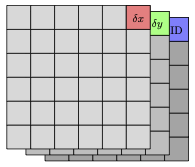


Often, two (or more) particles might attempt to occupy the same cell. In this case, we place the particles as close to their appropriate cell as possible, and some of the offsets ($\vec {\delta r_i} = \vec r_i - \vec c_{\vec n}$) will be larger than the cell size, $\ell$.

#### Spatial folding for parallelization

Structuring the data in this way will incur a significant penalty on TPU since the cache line processes matrices in chunks of $128\times 8$. To address this, we split the grid spatially into padded chunks and stack them to have shape $f_xf_y\times l_x\times l_y\times (d + 1)$ such that $f_xf_y$ is as close as possible to 128 and $f_xl_x = f_yl_y = L$ in two-dimensions (with an analogous form in three-dimensions). See the figure below for a visual description of this padding process.

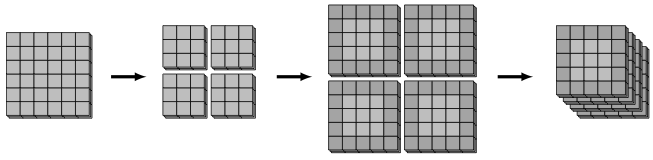

These chunks will be processed sequentially on the TPU without incurring waste due to underfilled cache line. We use a similar strategy to shard the system across multiple devices, with each chunk of the system processed in parallel along with halo-exchanges that occur after each simulation step.

In practice, in order to minimize the memory overhead associated with the halo,
and to avoid staleness in the halo, we store the stacked grid without its halo.
We then add the halo in a just-in-time fashion along a single axis immediately
before performing a 1d convolution or a particle swap.

#### Updating particle storage location

As particles move during the course of a simulation, they will often travel from one cell to another. To accommodate this motion we perform a particle swapping step at the end of each simulation step.

We define a loss $D$ which consists of the square norm of the total deviation of all particles from their corresponding cells,
$$D = \sum_i \left|\left| \vec {\delta r_i} \right|\right|^2_2.$$
We then propose to swap each grid cell with the $2d$ immediately adjacent grid cells. For instance, for a 2 dimensional grid, swaps are proposed with the grid cells above, below, left, and right of a target cell. Swaps are then accepted if the loss $D$ is lower after the swap than it was before the swap. In practice, this proposal and acceptance process is performed in parallel for all grid cells at once.

??? I want to say that because $D$ is convex, iterating this procedure is guaranteed to find an optimal assignment of particles to cells. I'm only about 80% sure this is true though. TODO -- think about this more???

Minimizing the loss $D$ corresponds to finding the assignment of particles to cells which minimizes distortion. 

### Computing displacements between particles using convolutions

Once particle positions are stored in the grid representation, displacements between neighboring particles, along with properties of the neighbors can be computed using separable convolutions. This information is generally sufficient to compute a large number of quantities of interest about the simulation. We will be concerned primarily with computing translation invariant quantities that can be expressed as a function of the displacement vectors between a central particle and its neighbors, $\vec r_{ij}$. Examples of such quantities include most classical potential energy functions that are local in the sense that they have compact support. 

Here we give a detailed description of two strategies that we employ for computing energies using convolutions. In the first case (I), we construct a full set of displacement vectors for each particle in the simulation and then compute the energy over the neighborhood as a separate pass. In the second case (II), we sequentially compute subsets of the displacement vectors along with their contribution to the energy. We then aggregate the contributions to compute the total energy. While these two approaches give the same energy, they offer different tradeoffs of memory, speed, and expressiveness. In particular the second method (II) only allows for the computation of energies that can be expressed as a sum over displacement vectors, $E = \sum_{ij} \varepsilon(\vec r_{ij})$ and so it excludes functions of bond-angles.

Central to both methods for computing displacements is the use of separable convolutions, with one convolution for each spatial dimension. Suppose we are computing a convolution over axis $\alpha=1$, $2$, $3$ with basis vector $\hat e_\alpha = \hat x$, $\hat y$, $\hat z$ respectively. The size of the convolutional filter is dictated by the range of the interactions and the size of the cells, so that $K = \lceil{\xi\over\ell}\rceil$. Each convolution has input dimension $d + 1$ (the spatial dimensions and the ID) and output dimension $(d + 1)K$ (one displacement and ID for each filter element). For spatial location $k$, input channel $c$, and output channel $o = (d + 1)k’ + c’$

$$W_{kco} = \delta_{kk’}\delta_{cc’}.$$

Defined in this way it follows that for the given spatial axis $\hat e_\alpha$,
$$g’_{\vec n o} = W\star g = \sum_{k,c} W_{kcc’}g_{(\vec n + k\hat e)c} = \sum_{k,c}\delta_{kk’}\delta_{cc’}g_{(\vec n + k\hat e)c} = g_{(\vec n + k’\hat e_\alpha)c’}.$$

Thus, $g’_{\vec n o}$ will contain information in component $c’$ about a particle in a cell with an offset $k’\hat e_\alpha$ from the center. 

We then instantiate a bias vector $b_o = k’\ell\delta_{c’\alpha}$ and add it to the result so that,
$$g’’_{\vec n o} = g’_{\vec n o} + b_{o} = g_{(\vec n + k’\hat e_\alpha)c’} + k’\ell\delta_{c’\alpha}$$

Gives the displacement vector from a given particle in cell $k’\hat e_\alpha$ to the center of the central cell. 

Once this is done, we reshape $g’’_{\vec n o}$ to have shape $l_x\times l_y\times (d + 1)\times K$ in two-dimensions or $l_x\times l_y\times l_z\times(d+1)\times K$ in three-dimensions. This can be regarded as $K$ copies of the grid with each copy containing the displacement of the central cell to the particle in the corresponding neighboring cell.

At this point, if we proceed along strategy (I), we repeat the separable convolution along the remaining axes until we have computed displacements to all $K^2$ cells in two-dimensions or $K^3$ cells in three-dimensions. Note that this will give the displacement vector from each particle to the _center_ of the central cell. However, we would almost always like to compute the displacement to the particle occupying the central cell. Thus, as a last step we subtract off the relative displacement of the central particle to compute the total displacement.

However, the cost of storing all of these displacements can become prohibitive for large systems or large neighborhoods (costing O(K^3) memory). As mentioned above, it can be much more efficient to accumulate the energy function over each cell separately. In this case, we suppose that we are given a function $f:\mathbb R^d\to\mathbb R^u$ that we would like to accumulate over the different neighbors. We would then loop over the $K$ copies of the grid and compute the next separable convolution over that copy. We do this recursively until all dimensions have been traversed and at the bottom level of the recursion we compute $f(\vec r_{ij})$ for each pair of cells and then sum the result. This involves performing $K^2$ sequential convolutions in two-dimensions and $K^3$ sequential convolutions in three-dimensions, but the memory cost remains $O(K)$ regardless of spatial dimension.

NOTE: This explanation is a little lacking, since it implies that k’ >=0; in practice, k’\in[-K,K] so the counting isn’t quite right.

NOTE: The code supports an additional auxiliary information vector associated with each particle, beyond the particle id. This information is manipulated in a similar fashion to the particle-id.

# Tutorial code using JAX, M.D. on TPU

We show how to define a molecular dynamics simulation, and scale it to run across multiple TPU devices to simulate tens of millions of particles. 

This code can be scaled up in a straightforward way to TPU pods of at least __ chips.

*Google-internal note -- you should run this notebook using the DragonDonut Brain Frameworks colab kernel.*

In [ ]:
#@title Imports and Utils

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
from jax import lax
import matplotlib.pyplot as plt

from jax_md import tpu
from jax_md.colab_tools import renderer

import warnings
warnings.filterwarnings('ignore')

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

## Fill a 2d box with particles

For easy visualization, we will start out by considering a small two-dimensional system. Later we'll show that we can run larger three-dimensional systems using the same approach. We first initialize a system of particles near vertices of a grid.

In [ ]:
box_size = 64

points = jnp.arange(box_size, dtype=jnp.float32)
X, Y = jnp.meshgrid(points, points)
position = jnp.stack((X.ravel(), Y.ravel()), axis=1)
position += random.normal(random.PRNGKey(0), position.shape) * 0.05
position = position % box_size

print(f'Particle Count: {len(position)}')

Particle Count: 4096


We can visualize the initial configuration using JAX MD's renderer.

In [ ]:
renderer.render(box_size,
                {'particles': renderer.Disk(position)},
                resolution=(512, 512))

The core idea is to phrase molecular dynamics simulation in terms of convolutions, and take advantage of hardware accelerated convolution operations. To do this, we must first discritize our system into an "image". Each pixel of the image can contain at most one particle. The image channels at each pixel coordinate represent, respectively, the X and Y offsets from the center of the pixel and the ID of the particle contained in the pixel. For more complex simulations, additional information can be stored about each particle by increasing the channel count.

To discritize our system we use the `to_grid` function.

In [ ]:
pixel_size = 0.5
interaction_distance = 1.1

grid = tpu.to_grid(position, box_size, pixel_size, interaction_distance)

Rather than arrange the system to be a single contiguous image, we instead build construct 128 patches of size 16x32. This allows us to use the TPU MXU more efficiently.

If we want to convert the data to a single contiguous image we can use the `unfold_mesh` utility function.

In [ ]:
print(f'The particle grid is stored in an array of shape {grid.cell_data.shape}')

unfolded_cell_data = tpu.unfold_mesh(grid.cell_data, grid)
print(f'If we unfold the grid, it corresponds to a 2d image of shape {unfolded_cell_data.shape}')

The particle grid is stored in an array of shape (128, 8, 16, 3)
If we unfold the grid, it corresponds to a 2d image of shape (128, 128, 3)


We can visualize the system by drawing pixels where the particle ID is nonzero.

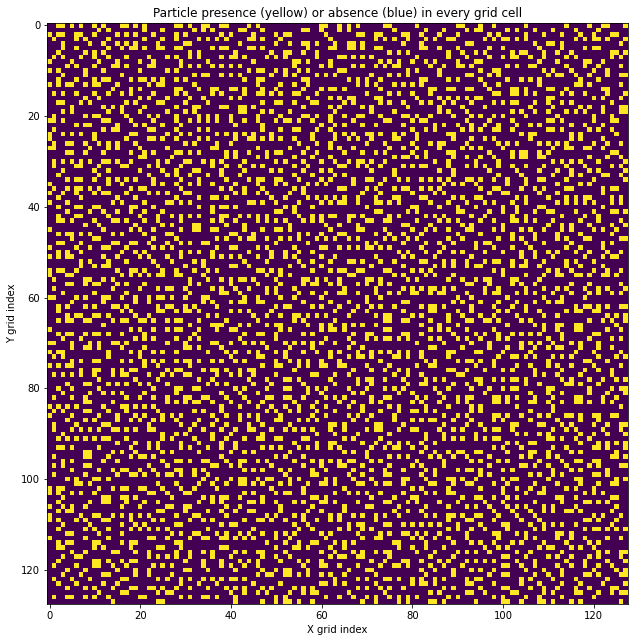

In [ ]:
plt.imshow(unfolded_cell_data[..., -1] > 0, interpolation='nearest')
plt.title('Particle presence (yellow) or absence (blue) in every grid cell')
plt.xlabel('X grid index')
plt.ylabel('Y grid index')
finalize_plot((1.5, 1.5))

We can also reconstruct positions from the grid and compare them to the original positions.

In [ ]:
reconstructed, particle_ids = tpu.from_grid(grid, aux=grid.cell_data[...,[-1]])
# sort in order of increasing particle id
ord = jnp.argsort(particle_ids.ravel())
reconstructed = reconstructed[ord]

jnp.allclose(reconstructed % box_size, position % box_size, atol=1e-5)

DeviceArray(True, dtype=bool)

## Computing energies, and forces

Now that we have prepared our system into a grid, we can use the TPU to compute various quantities on the system. As with most molecular dynamics applications, we will start out by defining an energy for the system. For the sake of this demonstration, we will use a simple potential called the `soft_sphere` potential. Here overlapping particles repel one another, but particles don't interact if they aren't overlapping.

To provide a baseline, we first compute the soft sphere energy in `float64` on CPU, using JAX, M.D..

In [ ]:
from jax_md import space, energy

displacement_fn, shift_fn = space.periodic(box_size)
cpu_neighbor_fn, cpu_energy_fn = energy.soft_sphere_neighbor_list(
    displacement_fn, box_size, sigma=interaction_distance)

CPU, = jax.devices('cpu')
cpu_position = jax.device_put(position, CPU)

cpu_nbrs = cpu_neighbor_fn(cpu_position)
jit(cpu_energy_fn)(cpu_position, cpu_nbrs)

DeviceArray(48.396294, dtype=float32)

Using our technique on TPU, the distance between neighboring atoms is computed using seperable convolutions. This allows us to take advantage of the MXU on the TPU while avoiding the $O(N^2)$ calculation of all pairwise distances. 

We now compute the soft sphere energy on TPU:

In [ ]:
energy_fn, force_fn = tpu.soft_sphere(sigma=interaction_distance)
energy_fn(grid)

DeviceArray(48.396305, dtype=float32)

 We can also compute the forces using the CPU baseline and TPU convolution code.

In [ ]:
from jax_md import quantity

cpu_forces = jit(quantity.force(cpu_energy_fn))(cpu_position, cpu_nbrs)
tpu_forces = force_fn(grid)
print(tpu_forces.shape)

(128, 8, 16, 2)


Notice that the TPU forces are still in the grid. To compare the forces, we have to extract them from the grid. We can do this by passing auxiliary data into the `from_grid` function.

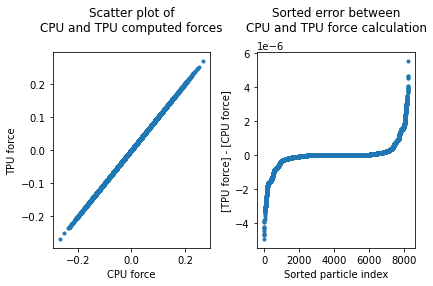

In [ ]:
_, unfolded_tpu_forces = tpu.from_grid(grid, aux=tpu_forces)
plt.subplot(1,2,1)
plt.plot(cpu_forces.reshape((-1,)), unfolded_tpu_forces.reshape((-1,)), '.')
plt.title('Scatter plot of\nCPU and TPU computed forces\n')
plt.xlabel('CPU force')
plt.ylabel('TPU force')
plt.subplot(1,2,2)
plt.plot(jnp.sort(unfolded_tpu_forces.reshape((-1,)) - cpu_forces.reshape((-1,))), '.')
plt.title('Sorted error between\nCPU and TPU force calculation\n')
plt.xlabel('Sorted particle index')
plt.ylabel('[TPU force] - [CPU force]')
plt.tight_layout()

We see good agreement between the two methods of computing energies and forces.

## Simulating molecular dynamics

In addition to computing quantities, we can also run simulations entirely on TPU. For this demo, we use a simple velocity-verlet integrator to simulate the system at constant energy. In this simulation, each particle will have a momentum associated with it as an auxiliary variable. This momentum is initialized by the `init_fn` returned by `tpu.nve`.

In [ ]:
init_fn, step_fn = tpu.nve(force_fn, 5e-3)

state = init_fn(random.PRNGKey(1), grid, kT=2e-2)

state = jax.device_put(state, jax.devices()[0]) # TODO DEBUG FIX THIS FOR REAL

We run a simulation and record the energy as we go.

In [ ]:
def sim_fn(i, state_energy):
  state, (kinetic_energy, potential_energy) = state_energy
  KE = tpu.kinetic_energy(state)
  PE = energy_fn(state.position)
  kinetic_energy = kinetic_energy.at[i].set(KE)
  potential_energy = potential_energy.at[i].set(PE)
  state = step_fn(state)
  return state, (kinetic_energy, potential_energy)

In [ ]:
steps = 1000
kinetic_energy = jnp.zeros((steps,))
potential_energy = jnp.zeros((steps,))

state, (kinetic_energy, potential_energy) = lax.fori_loop(0, steps, sim_fn, (state, (kinetic_energy, potential_energy)))

Text(0.5, 1.0, 'Simulation of a small 2d particle system')

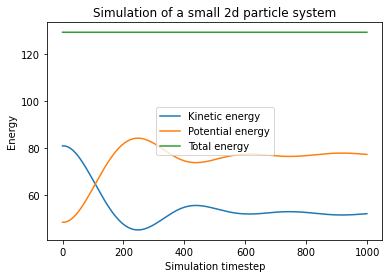

In [ ]:
plt.plot(kinetic_energy, label='Kinetic energy')
plt.plot(potential_energy, label='Potential energy')
plt.plot(kinetic_energy + potential_energy, label='Total energy')
plt.legend()
plt.xlabel('Simulation timestep')
plt.ylabel('Energy')
t = plt.title('Simulation of a small 2d particle system')

As expected, we see that energy is conserved throughout the simulation. Note that for the purposes of the demo, we have used a larger timestep than would be used in practice.

We can draw the final position of the particles.

In [ ]:
pos = tpu.from_grid(state.position)
renderer.render(box_size,
                {'particles': renderer.Disk(pos)},
                resolution=(512, 512))

## Scaling to *many* more particles, and from 2d to 3d

So far we have only used part of a single core on one TPU. However, we support simulations that are distributed over multiple cores. To demonstrate this, we'll run a significantly larger simulation split across multiple TPU cores.

All of the code also works in three dimensions. The TPU "donut" topology is particularly well-suited to three dimensional systems. To create a three dimensional system we only have to add a third dimension to the positions.

In [ ]:
box_size = 72
pixel_size = 0.5
interaction_distance = 1.1

# TODO increase particle density
# points = jnp.arange(box_size, dtype=jnp.float32) 
# choose a point density such that half the grid cells will be occupied in 3d
points = jnp.linspace(0., box_size-1., int((box_size/pixel_size)*0.5**(1/3.)), dtype=jnp.float32) 
X, Y, Z = jnp.meshgrid(points, points, points)
position = jnp.stack((X.ravel(), Y.ravel(), Z.ravel()), axis=1)
position += random.normal(random.PRNGKey(0), position.shape) * 0.05
position = position % box_size

print(f'Particle Count: {len(position)}')

Particle Count: 1481544


To tell JAX MD that we would like to distribute the calculation over multiple cores we set the `topology` keyword argument when we construct the grid. We will use all 8 chips in a Dragon Donut, specifying the topology to be `(2, 2, 2)`.

In [ ]:
grid = tpu.to_grid(position, box_size, pixel_size, interaction_distance,
                   topology=(2, 2, 2))

print(f'{type(grid.cell_data)} of shape {grid.cell_data.shape}.')

<class 'google3.third_party.tensorflow.compiler.xla.python.xla_extension.pmap_lib.ShardedDeviceArray'> of shape (2, 2, 2, 128, 10, 20, 20, 4).


Now the grid is a sharded device array over a 2x2x2 mesh of the TPU. As before, we can extract positions from the grid.

In [ ]:
reconstructed, particle_ids = tpu.from_grid(grid, aux=grid.cell_data[...,[-1]])
# sort in order of increasing particle id
ord = jnp.argsort(particle_ids.ravel())
reconstructed = reconstructed[ord]

jnp.allclose(reconstructed % box_size, position % box_size, atol=1e-4)

DeviceArray(True, dtype=bool)

We can still compute energies (and forces). Unlike before, this computation will be parallelized across the TPU mesh.

In [ ]:
energy_fn(grid)

DeviceArray(578467.6, dtype=float32)

As before we can run a simulation at constant energy. Note that there are no changes to the code going from single core to multi-core mode -- we are reusing the `sim_fn` and `force_fn` defined above. 

TODO: Is the following still accurate?
However, execution speed could be improved since we currently do `jit`-of-`pmap` whereas JAX prefers `pmap`-of-`jit`. The current phrasing also collects all of the data onto a single core when computing the total energy.

In [ ]:
%%time

steps = 1000
kinetic_energy = jnp.zeros((steps,))
potential_energy = jnp.zeros((steps,))

init_fn, step_fn = tpu.nve(force_fn, 5e-3)
state = init_fn(random.PRNGKey(1), grid, kT=2e-2)

state, (kinetic_energy, potential_energy) = lax.fori_loop(0, steps, sim_fn, (state, (kinetic_energy, potential_energy)))
potential_energy = potential_energy.block_until_ready()

CPU times: user 1min 27s, sys: 5.17 s, total: 1min 33s
Wall time: 9min 15s


Text(0.5, 1.0, 'Simulation of 1481544 particles in a 3d box')

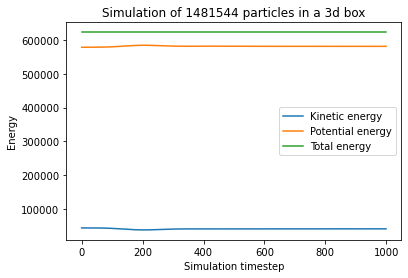

In [ ]:
plt.plot(kinetic_energy, label='Kinetic energy')
plt.plot(potential_energy, label='Potential energy')
plt.plot(kinetic_energy + potential_energy, label='Total energy')
plt.legend()
plt.xlabel('Simulation timestep')
plt.ylabel('Energy')
t = plt.title(f'Simulation of {len(position)} particles in a 3d box')

Once again, we can render the system; however, it might slow down your computer to a crawl depending on your GPU!

In [ ]:
renderer.render(box_size,
                {'particles': renderer.Sphere(tpu.from_grid(state.position))},
                resolution=(1024, 1024))

# Discussion

This Colab introduces a prototype for performing molecular dynamics computations on TPU. The implementation introduced here discretizes the system into pixels or voxels and then phrases common operations in terms of swapping moves or convolutions on top of this discrete representation.

There are clearly upsides to this approach: TPUs are fast and have a lot of memory, and this technique can scale to tens-of-millions of particles on a DragonDonut. It seems as though, were we able to run experiments on larger TPU configurations, we could compete with national supercomputing clusters in terms of system size. Moreover, it is relatively straight forward to scale to multiple TPUs and the topology of TPU chips makes them well-suited for simulating three-dimensional systems.

Finally, there are certain aspects of the current implementation that are quite brittle. First and foremost, when constructing a grid, great care must be taken so that the number of cells can be reshaped to have a batch dimension of size 128. This seems important if we are to use the TPU most efficiently. Second, the current implementation can lead to configurations where multiple particles would like to occupy the same cell (or frustrated configurations where a particle cannot reach its desired cell). In principle this is okay, as long as the particle doesn't stray so far so as fall outside the neighborhood of a close by particle. However, we do not detect when this occurs which makes these simulations unsafe in practice. Fortunately, I think this particular issue should have a relatively straight forward resolution.

